# Validation

In [1]:
import os
import util.util_validation as ut_val
from util.util_logging import add_confusion_matrix_to_run_md, create_comb_md

### Parameters

In [9]:
cuda_device = 0
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

root_model = "./save/SupCE/animals10_diff_-1_small/SupCE_animals10_diff_-1_small_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_origSmall_cosine/models/last.pth"
# root_model = "./save/SupCE/animals10_diff_4000_small/SupCE_animals10_diff_4000_small_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000Small_cosine/models/last.pth"
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAug_cosine/models/last.pth"
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"
# root_model = "./save/SupCon/animals10_diff_-1/SupCon_animals10_diff_-1_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_try3_cosine/models/last.pth"

dataset_val = "animals10_diff_4000"
dataset_val_2 = "animals10_diff_-1"


tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

root_train, root_test = ut_val.get_root_dataset(dataset_val)

if dataset_val_2:
    root_train_2, root_test_2 = ut_val.get_root_dataset(dataset_val_2)
    path_save, path_run_md, path_val_md, path_val_md_2, path_comb_md, path_comb, path_embeddings, path_embeddings_2, epoch = ut_val.get_paths_to_embeddings_and_run_md(root_model, dataset_val, dataset_val_2)
else:
    path_save, path_run_md, path_val_md, path_embeddings, epoch = ut_val.get_paths_to_embeddings_and_run_md(root_model, dataset_val)

params = ut_val.read_parameters_from_run_md(path_run_md)

### Dataloader and Model

In [5]:
train_loader, val_loader = ut_val.set_dataloader(dataset_val, params, root_train, root_test)
if dataset_val_2:
    train_loader_2, val_loader_2 = ut_val.set_dataloader(dataset_val_2, params, root_train_2, root_test_2)

model = ut_val.set_model(root_model, params, len(val_loader.dataset.classes), cuda_device)

### Compute Embedding

In [6]:
embedding_train, class_labels_train, embedding_test, class_labels_test = ut_val.compute_and_save_embeddings(model, dataset_val, train_loader, val_loader, path_val_md, path_embeddings, params, cuda_device)

if dataset_val_2:
    embedding_train_2, class_labels_train_2, embedding_test_2, class_labels_test_2 = ut_val.compute_and_save_embeddings(model, dataset_val_2, train_loader_2, val_loader_2, path_val_md_2, path_embeddings_2, params, cuda_device)

100%|██████████| 202/202 [00:59<00:00,  3.38it/s]


### t-SNE

In [7]:
!CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings}

Data split train
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
compute t-SNE embedding
writ t-SNE embedding


In [8]:
!CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings_2}

Data split train
load feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
compute t-SNE embedding
writ t-SNE embedding


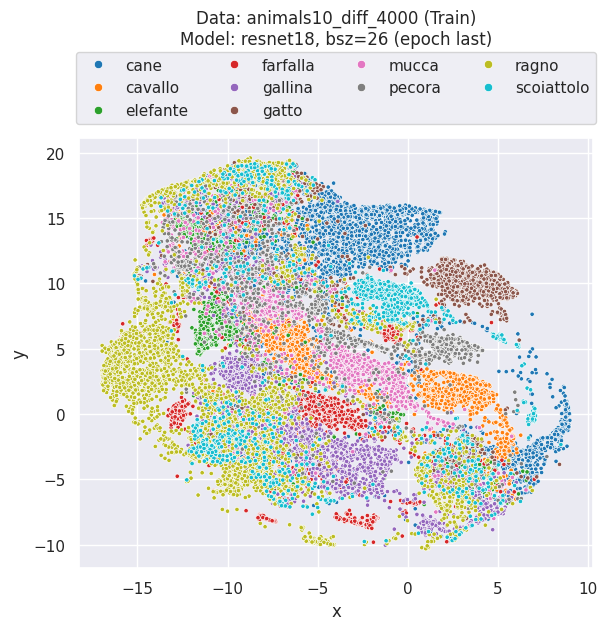

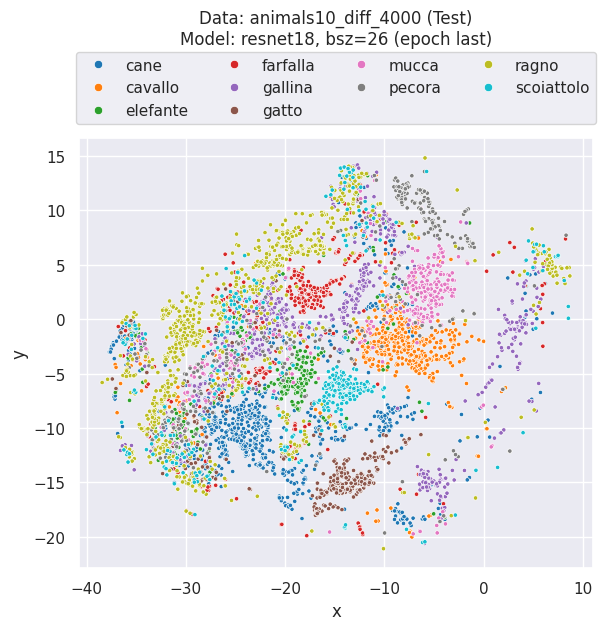

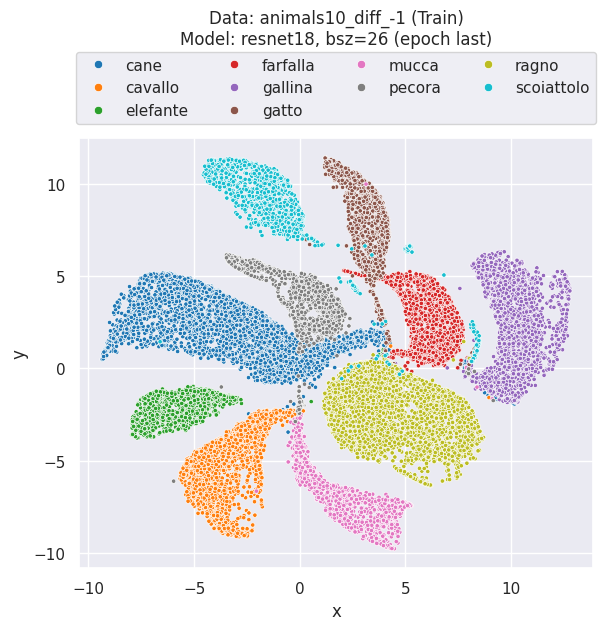

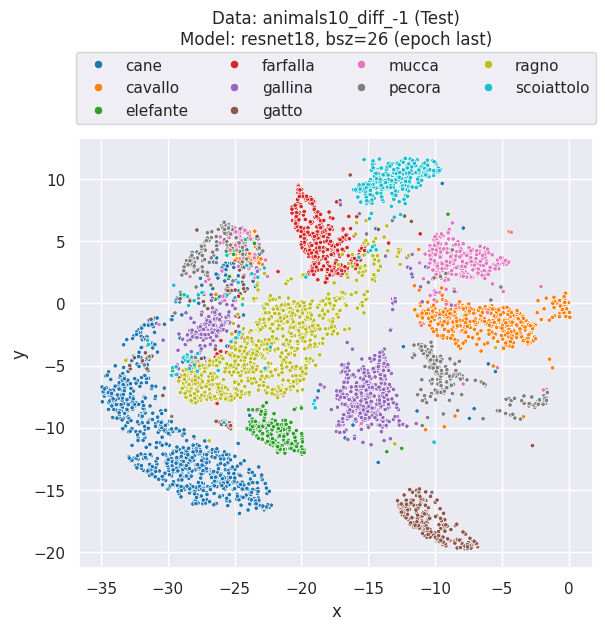

In [9]:
ut_val.save_tSNE_plots(dataset_val, path_val_md, path_embeddings, params, epoch)

if dataset_val_2:
    ut_val.save_tSNE_plots(dataset_val_2, path_val_md_2, path_embeddings_2, params, epoch)

### Classifier

In [4]:
classifier_training_call = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                          + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                          + f" --model {params['model']} --dataset {params['dataset']}"\
                          + f" --data_folder {os.path.join(path_embeddings, 'embedding_train')}"\
                          + f" --test_folder {os.path.join(path_embeddings, 'embedding_test')}"\
                          + " --num_classes 10 --pre_comp_feat"\
                          + f" --tag Epoch{epoch}"\
                          + (f" --md_file val_{dataset_val}.md" if params['dataset'] != dataset_val else "")\
                          + " > precomp_classifier.out"

if dataset_val_2:
    classifier_training_call_2 = f"CUDA_VISIBLE_DEVICES={cuda_device} nohup python main_linear.py"\
                            + " --batch_size 256 --batch_size_val 256 --epochs 30 --learning_rate 5"\
                            + f" --model {params['model']} --dataset {params['dataset']}"\
                            + f" --data_folder {os.path.join(path_embeddings_2, 'embedding_train')}"\
                            + f" --test_folder {os.path.join(path_embeddings_2, 'embedding_test')}"\
                            + " --num_classes 10 --pre_comp_feat"\
                            + f" --tag Epoch{epoch}"\
                            + (f" --md_file val_{dataset_val_2}.md" if params['dataset'] != dataset_val_2 else "")\
                            + " > precomp_classifier.out"

In [5]:
!{classifier_training_call}

nohup: ignoring input and redirecting stderr to stdout


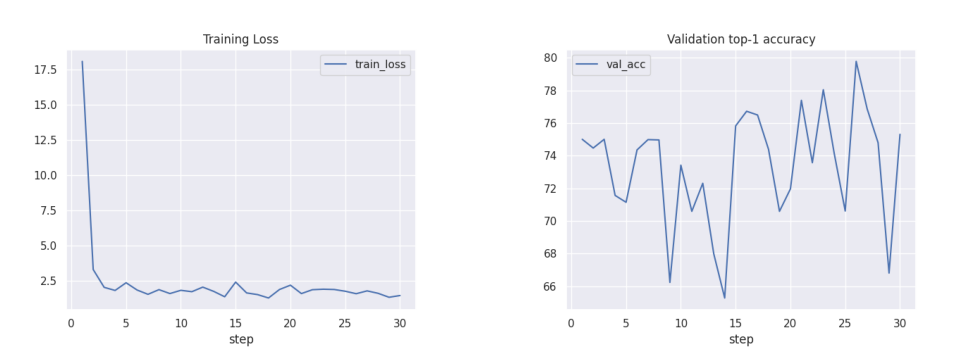

In [6]:
path_classifier = ut_val.get_path_classifier(root_model, dataset_val, params, epoch)
ut_val.move_classifier_out_file(path_classifier)

ut_val.load_classifier_plots(path_classifier)

In [13]:
!{classifier_training_call_2}

nohup: ignoring input and redirecting stderr to stdout


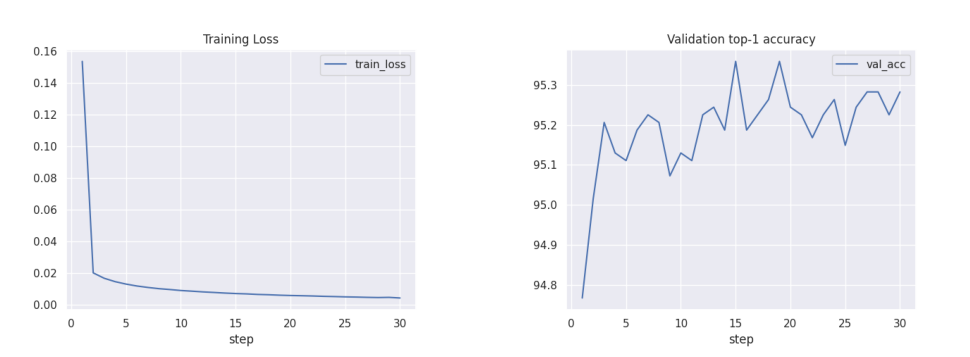

In [14]:
if dataset_val_2:
    path_classifier_2 = ut_val.get_path_classifier(root_model, dataset_val_2, params, epoch)
    ut_val.move_classifier_out_file(path_classifier_2)

    ut_val.load_classifier_plots(path_classifier_2)

### Classifier individual Class Accuracies

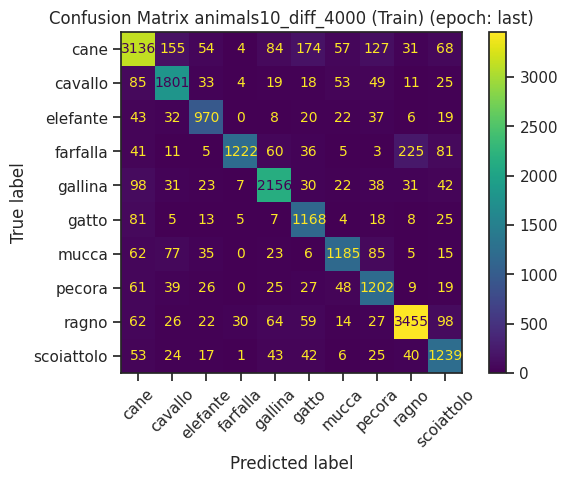

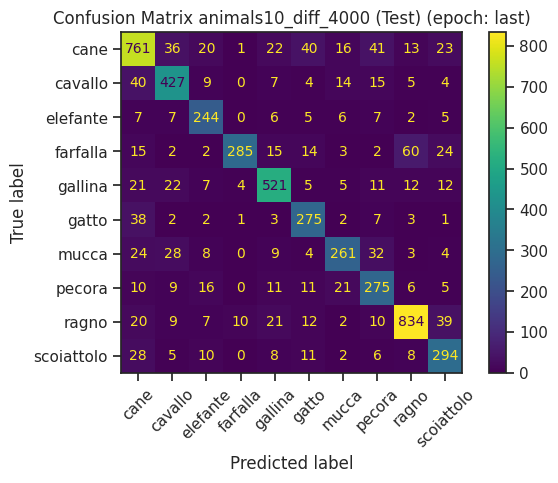

In [7]:
C_train, acc_train, acc_b_train, C_val, acc_val, acc_b_val = ut_val.compute_and_save_confusion_matrix(root_model, dataset_val, path_embeddings, params, epoch, cuda_device)
path_classifier = ut_val.get_path_classifier(root_model, dataset_val, params, epoch)
add_confusion_matrix_to_run_md(path_class=path_classifier, acc=acc_val, acc_b=acc_b_val, train_acc=acc_train, train_acc_b=acc_b_train, md_file=(f"val_{dataset_val}.md" if params['dataset']!=dataset_val else None))

if dataset_val_2:
    C_train_2, acc_train_2, acc_b_train_2, C_val_2, acc_val_2, acc_b_val_2 = ut_val.compute_and_save_confusion_matrix(root_model, dataset_val_2, path_embeddings_2, params, epoch, cuda_device)
    path_classifier_2 = ut_val.get_path_classifier(root_model, dataset_val_2, params, epoch)
    add_confusion_matrix_to_run_md(path_class=path_classifier_2, acc=acc_val_2, acc_b=acc_b_val_2, train_acc=acc_train_2, train_acc_b=acc_b_train_2, md_file=(f"val_{dataset_val_2}.md" if params['dataset']!=dataset_val_2 else None))

### Combine Two Dataset Results

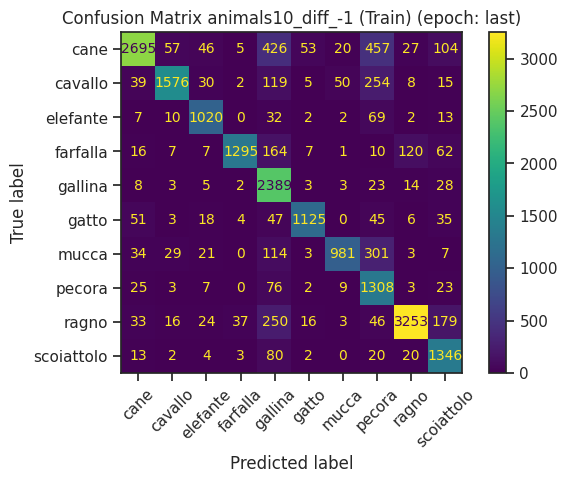

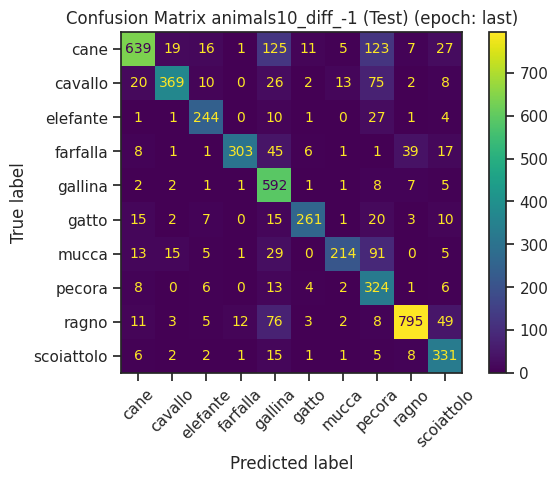

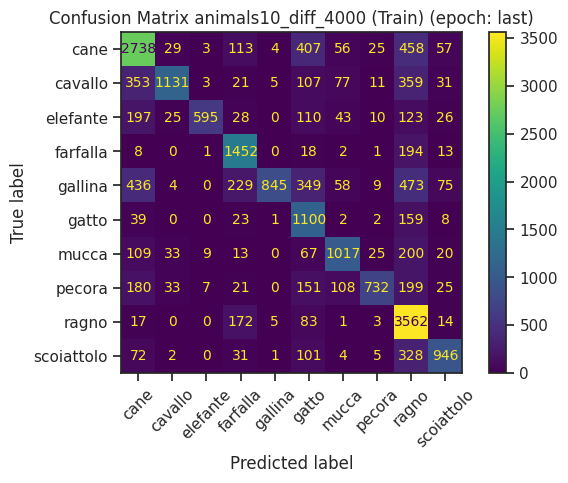

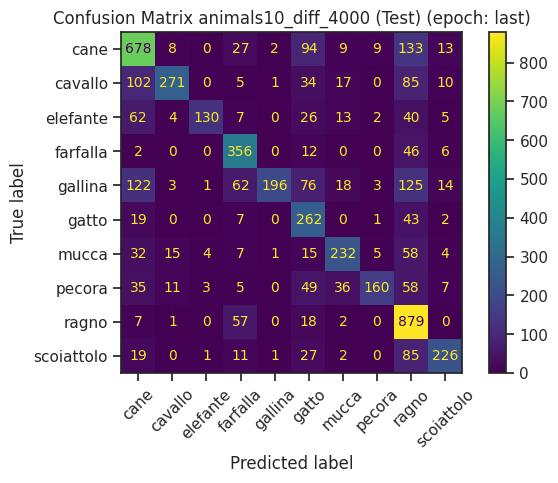

In [10]:
all_epochs, comb_dict =  ut_val.get_comb_results(root_model, dataset_val, dataset_val_2, path_save, path_comb, path_embeddings, path_embeddings_2, params, epoch, cuda_device)
create_comb_md(path_comb_md, path_save, dataset_val, dataset_val_2, all_epochs, comb_dict)

-----------------------

## Add Training Info to interrupted Runs

In [6]:
import os
import glob
import re
from util.util_logging import create_training_plots, create_crossentropy_plots
from util.util_logging import add_train_to_run_md, add_class_CE_to_run_md

In [ ]:
def add_tain_to_supCon_run(path_run_md):
    # add training details to the run.md file
    create_training_plots(path=path_run_md)
    add_train_to_run_md(path=path_run_md)

def add_tain_to_supCE_run(path_run_md, path_out):
    path_out = glob.glob(os.path.join(path_out, "supCE*.out"))[0]
    file_out = glob.glob(os.path.join(path_run_md, "out", "*.out"))[0]

    with open(file_out, 'r') as f:
        file = f.read()

    fiel_val_accs = re.findall("\* Acc@1 [0-9]+\.[0-9]+", file)

    best_acc = 0
    for str_val_acc in fiel_val_accs:
        val_acc = float(str_val_acc.replace("* Acc@1 ", ''))
        if val_acc > best_acc:
            best_acc = val_acc

    best_acc

    # add training and validation details to the run.md file
    create_crossentropy_plots(path=path_run_md)
    add_train_to_run_md(path=path_run_md)
    add_class_CE_to_run_md(path=path_run_md, best_acc=best_acc)

In [7]:
path_run_md = "./save/SupCE/animals10/SupCE_animals10_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_noCosine/"

path_out = os.path.join(path_run_md, "out")

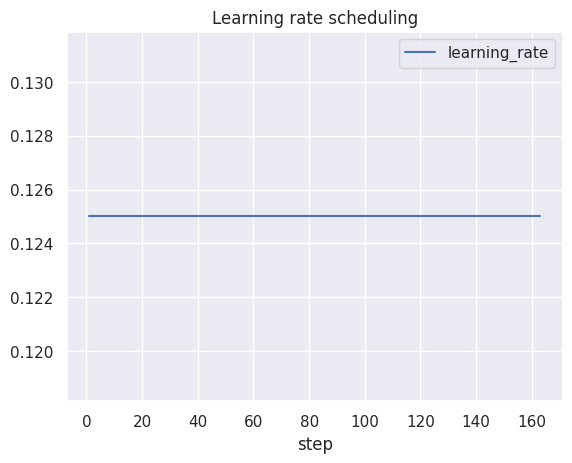

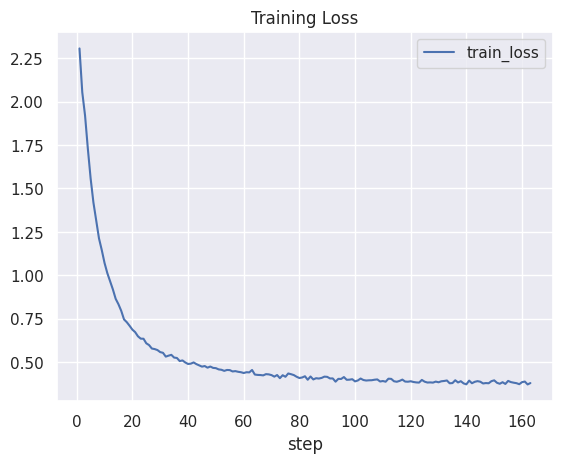

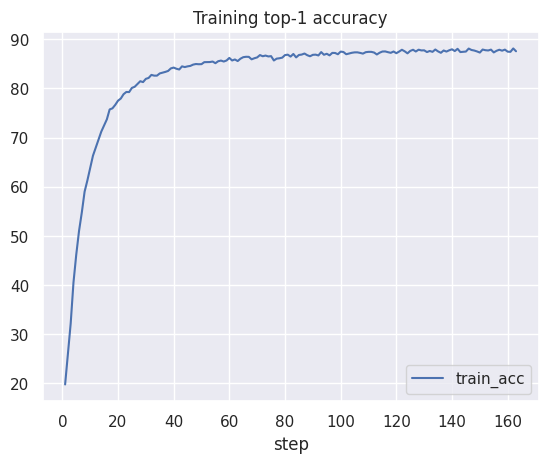

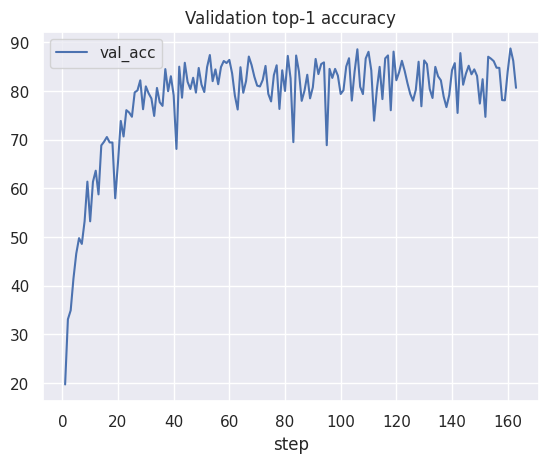

In [34]:
add_tain_to_supCE_run(path_run_md, path_out)